In [4]:
import json
import os

import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Lets count how much data we have!
verified_directory = 'data/advisories/github-reviewed'
community_directory = 'data/advisories/unreviewed'

verified_count = 0
community_count = 0
for root, dirs, files in os.walk(verified_directory):
    verified_count += len(files)
for root, dirs, files in os.walk(community_directory):
    community_count += len(files)

print(f"Verified: {verified_count}")
print(f"Community: {community_count}")
print(f"Total: {verified_count + community_count}")

Verified: 20375
Community: 231666
Total: 252041


In [158]:
def load_cwes(directory):
    cwes = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            # If the file is a JSON, then we want to print the path
            if not file.endswith('.json'):
                continue
            with open(os.path.join(root, file), 'r') as f:
                data = json.load(f)
                cwes += data['database_specific']['cwe_ids']
    for i in range(len(cwes)):
        cwes[i] = cwes[i].replace('CWE-', '')
    return cwes

cwes = load_cwes(verified_directory)
# Do some preprocessing to strip the `CWE-` prefix

438
Maximum count of labels:  3280


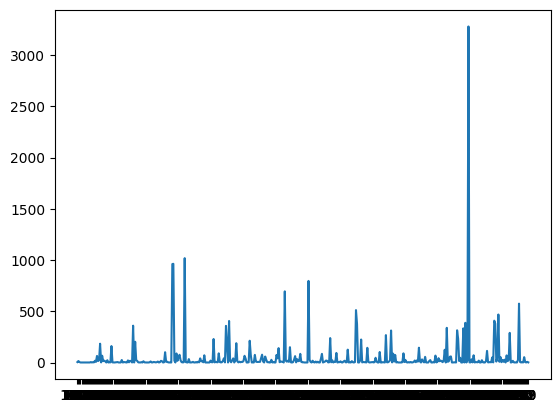

In [159]:
cwes_np = np.array(cwes)
unique, counts = np.unique(cwes_np, return_counts=True)
print(len(unique))
print("Maximum count of labels: ", max(counts))
plt.plot(unique, counts)

In [160]:
# Let's load in the trie to see how the hierarchy breaks down
with open("data/cwe_tree.json", 'r') as f:
    cwe_tree = json.load(f)

In [167]:
# Let's build a Tree structure so we can properly do data classification
class TreeNode:
    def __init__(self, id: int, parents: list = []):
        self.id = id
        self.parents = parents
        self.count = 0

def generate_cwe_tree_dict():
    cwe_tree_dict = {}
    for parent, children in cwe_tree.items():
        for child in children:
            if child in cwe_tree_dict:
                cwe_tree_dict[child].parents.append(parent)
            else:
                cwe_tree_dict[child] = TreeNode(child, [parent])
            if parent not in cwe_tree_dict:
                cwe_tree_dict[parent] = TreeNode(parent, [])
    return cwe_tree_dict

In [168]:
# Let's propagate the counts upwards so we can get an accurate idea of how the hierarchies break down
# Let's also note that because a child can have multiple parents, there is a possibility of double counting. This is OK, as this would map to multiple labels being produced when we do the topic classification

def propagate_cwes_up_tree(cwe_list):
    cwe_tree_dict = generate_cwe_tree_dict()
    for i in cwe_list:
        parent_queue = [str(i)]
        parent_queue_idx = 0
        while parent_queue_idx < len(parent_queue):
            node = parent_queue[parent_queue_idx]
            parent_queue_idx += 1
            if node not in cwe_tree_dict:
                continue
            curr_parents = cwe_tree_dict[node].parents
            for j in curr_parents:
                if j not in parent_queue:
                    parent_queue.append(j)
            cwe_tree_dict[node].count += 1
    return cwe_tree_dict

cwe_tree_dict = propagate_cwes_up_tree(cwes)
print(cwe_tree_dict['319'].count)

85


In [169]:
# How does the count break down at the root level?
first_level = []
for i in cwe_tree_dict.values():
    if len(i.parents) == 0:
        first_level.append(i.id)

for i in first_level:
    print(i, cwe_tree_dict[i].count)

707 8031
664 9487
682 220
693 1862
697 89
435 153
703 498
284 3394
691 661
710 735


# Unverified Advisories

In [164]:
# This is going to take a minute, but let's check out the unreviewed data
unverified_cwes = load_cwes(community_directory)

570
Maximum count of labels:  25258


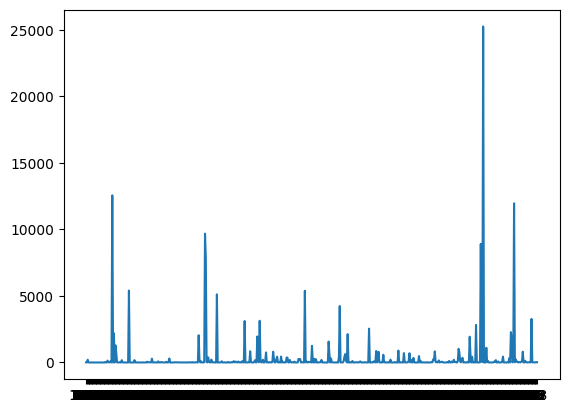

In [166]:
cwes_np = np.array(unverified_cwes)
unique, counts = np.unique(cwes_np, return_counts=True)
print(len(unique))
print("Maximum count of labels: ", max(counts))
plt.plot(unique, counts)

In [173]:
unverified_cwe_tree_dict = propagate_cwes_up_tree(unverified_cwes)

# How does the count break down at the root level?
first_level = []
for i in unverified_cwe_tree_dict.values():
    if len(i.parents) == 0:
        first_level.append(i.id)

for i in first_level:
    print(i, unverified_cwe_tree_dict[i].count)

707 96169
664 73717
682 2734
693 10387
697 133
435 206
703 3813
284 21234
691 3314
710 4895
